Test out the bias-corrected $k$NN KL divergence estimates in Wang et al. (2009)

In [1]:
import numpy as np
from scipy.linalg import sqrtm
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors
from scipy.stats import multivariate_normal 
from numpy.random import multivariate_normal as mvn 
# -- nonGaussLike -- 
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

implement 

$$D^{(1)}(X_{1:n} || Y_{1:m}) = \frac{1}{n} \sum\limits_{i=1}^{n}[\psi(l_i) - \psi(k_i)] + \log \frac{m}{n-1}$$

In [3]:
def divest0(X,Y, k=5): 
    assert X.shape[1] == Y.shape[1] 
    d = X.shape[1] # dimensions
    n = X.shape[0] # X sample size
    m = Y.shape[0] # Y sample size
    
    NN_X = NearestNeighbors(n_neighbors=k+1).fit(X)
    NN_Y = NearestNeighbors(n_neighbors=k).fit(Y)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=k+1)
    dNN_XY, _ = NN_Y.kneighbors(X, n_neighbors=k)
    rho_i = dNN_XX[:,-1]
    nu_i = dNN_XY[:,-1]
    return float(d)/float(n) * np.sum(np.log(nu_i / rho_i)) + np.log(float(m)/float(n - 1))

In [4]:
def divest1(X, Y): 
    assert X.shape[1] == Y.shape[1] 
    d = X.shape[1] # dimensions
    n = X.shape[0] # X sample size
    m = Y.shape[0] # Y sample size
    
    # first determine epsilon(i) 
    NN_X = NearestNeighbors(n_neighbors=1).fit(X)
    NN_Y = NearestNeighbors(n_neighbors=1).fit(Y)
    dNN1_XX, _ = NN_X.kneighbors(X, n_neighbors=2)
    dNN1_XY, _ = NN_Y.kneighbors(X)   
    eps = np.amax([dNN1_XX[:,1], dNN1_XY[:,0]], axis=0) * 1.000001
    
    # find l_i and k_i
    _, i_l = NN_X.radius_neighbors(X, eps)
    _, i_k = NN_Y.radius_neighbors(X, eps)
    l_i = np.array([len(il)-1 for il in i_l])
    k_i = np.array([len(ik) for ik in i_k])
    return np.sum(digamma(l_i) - digamma(k_i)) / float(n) + np.log(float(m)/float(n-1))

In [5]:
def divest2(X, Y): 
    assert X.shape[1] == Y.shape[1] 
    d = X.shape[1] # dimensions
    n = X.shape[0] # X sample size
    m = Y.shape[0] # Y sample size
    
    # first determine epsilon(i) 
    NN_X = NearestNeighbors(n_neighbors=1).fit(X)
    NN_Y = NearestNeighbors(n_neighbors=1).fit(Y)
    dNN1_XX, _ = NN_X.kneighbors(X, n_neighbors=2)
    dNN1_XY, _ = NN_Y.kneighbors(X)   
    eps = np.amax([dNN1_XX[:,1], dNN1_XY[:,0]], axis=0) * 1.000001
    
    # find l_i and k_i
    _, i_l = NN_X.radius_neighbors(X, eps)
    _, i_k = NN_Y.radius_neighbors(X, eps)
    l_i = np.array([len(il)-1 for il in i_l])
    k_i = np.array([len(ik) for ik in i_k])
    #assert l_i.min() > 0
    #assert k_i.min() > 0

    rho_i = np.empty(n, dtype=float)
    nu_i = np.empty(n, dtype=float)
    for i in range(n): 
        rho_ii, _ = NN_X.kneighbors(np.atleast_2d(X[i]), n_neighbors=l_i[i]+1)
        nu_ii, _ = NN_Y.kneighbors(np.atleast_2d(X[i]), n_neighbors=k_i[i])
        rho_i[i] = rho_ii[0][-1]
        nu_i[i] = nu_ii[0][-1]
    
    d_corr = float(d) / float(n) * np.sum(np.log(nu_i/rho_i))
    return d_corr + np.sum(digamma(l_i) - digamma(k_i)) / float(n) + np.log(float(m)/float(n-1))

In [6]:
def divest3(X, Y): 
    assert X.shape[1] == Y.shape[1] 
    d = X.shape[1] # dimensions
    n = X.shape[0] # X sample size
    m = Y.shape[0] # Y sample size
    
    mu = 1./float(n + m) * (np.sum(X, axis=0) + np.sum(Y, axis=0))
    
    _Cx = np.sum([np.dot((X[i] - mu)[:,None], (X[i] - mu)[None,:]) for i in range(n)], axis=0)
    _Cy = np.sum([np.dot((Y[i] - mu)[:,None], (Y[i] - mu)[None,:]) for i in range(m)], axis=0)
    C = 1./float(n + m - 1) * (_Cx + _Cy)

    Cinvsqrt = np.linalg.inv(sqrtm(C))
    Xp = np.dot(Cinvsqrt, (X - mu).T).T
    Yp = np.dot(Cinvsqrt, (Y - mu).T).T
    return divest1(Xp, Yp)

Lets test the $k$-NN KL divergence on the simplest 1D gaussian samples drawn from the same distribution --- _i.e._

$$ KL(p(x) || p(x)) $$ where $p(x)$ is 1D Gaussian

In [7]:
Xn = np.random.normal(size=1000)
Yn = np.random.normal(size=1200)

(-3.0, 3.0)

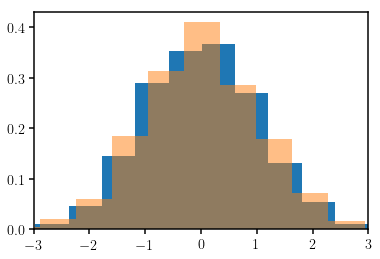

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(Xn, density=True)
sub.hist(Yn, density=True, alpha=0.5)
sub.set_xlim([-3., 3.])

In [11]:
ns = [1e1, 1e2, 1e3, 2e3, 3e3, 4e3]
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for n in ns: 
    Xn = np.random.normal(size=int(n))
    Yn = np.random.normal(size=int(n))
    
    div00.append(NG.kNNdiv_gauss(Xn.reshape(-1,1), None, Knn=5, div_func='kl', gauss=Yn.reshape(-1,1)))
    div0.append(divest0(Xn.reshape(-1,1), Yn.reshape(-1,1), k=1))
    div1.append(divest1(Xn.reshape(-1,1), Yn.reshape(-1,1)))
    div2.append(divest2(Xn.reshape(-1,1), Yn.reshape(-1,1)))
    div3.append(divest3(Xn.reshape(-1,1), Yn.reshape(-1,1)))

(-0.1, 0.1)

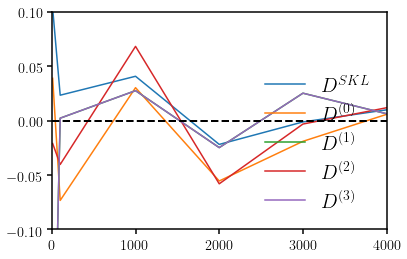

In [12]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, div00, label=r"$D^{SKL}$")
sub.plot(ns, div0, label=r"$D^{(0)}$")
sub.plot(ns, div1, label=r"$D^{(1)}$")
sub.plot(ns, div2, label=r"$D^{(2)}$")
sub.plot(ns, div3, label=r"$D^{(3)}$")
sub.legend(loc='lower right', fontsize=20)
sub.plot([0., 4e3], [0., 0.], c='k', lw=2, ls='--')
sub.set_xlim([0., 4e3])
sub.set_ylim([-0.1, 0.1])

All three $k$-NN estimates converge to the correct answer for the simplest case.

Now lets try changing $p(x)$ and $q(x)$. 

#### Test 1
$KL(p || q)$ where $p(x) = \mathcal{N}(0, 1)$ and $q(x) = \mathcal{N}(0, 0.5)$

(0.0, 10.0)

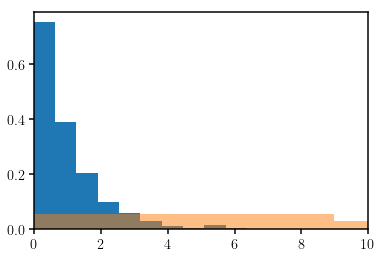

In [13]:
Xn = np.random.exponential(1., size=1000)
Yn = np.random.exponential(12, size=1000)
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(Xn, density=True)
sub.hist(Yn, density=True, alpha=0.5)
sub.set_xlim([0., 10.])

In [14]:
ns = [1e1, 1e2, 1e3, 2e3, 3e3, 4e3, 1e4]
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for n in ns: 
    Xn = np.random.exponential(1., size=int(n))
    Yn = np.random.exponential(12, size=int(n))
    
    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        d00 += NG.kNNdiv_gauss(Xn.reshape(-1,1), None, Knn=5, div_func='kl', gauss=Yn.reshape(-1,1))
        d0 += divest0(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d1 += divest1(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d2 += divest2(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d3 += divest3(Xn.reshape(-1,1), Yn.reshape(-1,1))
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(0.0, 10000.0)

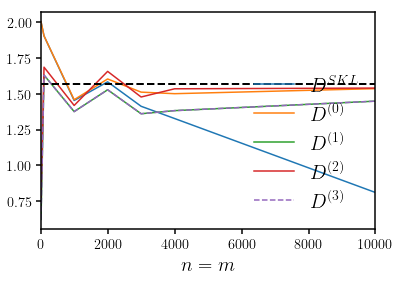

In [17]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ns, div00, label=r"$D^{SKL}$")
sub.plot(ns, div0, label=r"$D^{(0)}$")
sub.plot(ns, div1, label=r"$D^{(1)}$")
sub.plot(ns, div2, label=r"$D^{(2)}$")
sub.plot(ns, div3, ls='--', label=r"$D^{(3)}$")
sub.legend(loc='lower right', fontsize=20)
sub.plot([0., 1e4], [1.5682, 1.5682], c='k', lw=2, ls='--')
sub.set_xlabel('$n = m$', fontsize=20)
sub.set_xlim([0., 1e4])
#sub.set_ylim([0.4, 0.85])

#### Test 2: 
Multivariate example from Wang et al. (2009) Figure 2

In [18]:
mu_p = np.array([0.1, 0.3, 0.6, 0.9])
mu_q = np.array([0., 0., 0., 0.])
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.5
            cov_q[i,j] = 0.1

In [19]:
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    Yn = mvn(mu_q, cov_q, size=int(n))

    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        d00 += NG.kNNdiv_gauss(Xn, None, Knn=5, div_func='kl', gauss=Yn)
        d0 += divest0(Xn, Yn, k=1)
        d1 += divest1(Xn, Yn)
        d2 += divest2(Xn, Yn)
        d3 += divest3(Xn, Yn)
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(0.0, 10000.0)

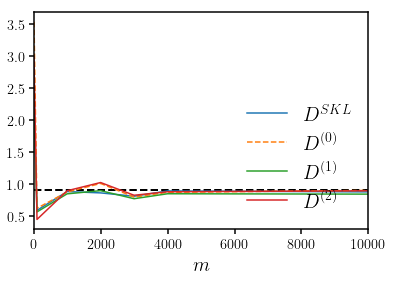

In [20]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 1e4], [0.9009, 0.9009], c='k', lw=2, ls='--')
sub.plot(ns, div00, label=r"$D^{SKL}$")
sub.plot(ns, div0, ls='--', label=r"$D^{(0)}$")
sub.plot(ns, div1, label=r"$D^{(1)}$")
sub.plot(ns, div2, label=r"$D^{(2)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$m$', fontsize=20)
sub.set_xlim([0., 1e4])

#### Test 3: 
Wang et al. (2009) Figure 4

In [24]:
mu_p = np.zeros(20)
mu_q = np.zeros(20)
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.2
            cov_q[i,j] = 0.2

In [25]:
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    Yn = mvn(mu_q, cov_q, size=int(n))

    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        d00 += NG.kNNdiv_gauss(Xn, None, Knn=5, div_func='kl', gauss=Yn)
        d0 += divest0(Xn, Yn, k=1)
        d1 += divest1(Xn, Yn)
        d2 += divest2(Xn, Yn)
        d3 += divest3(Xn, Yn)
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(-0.1, 0.1)

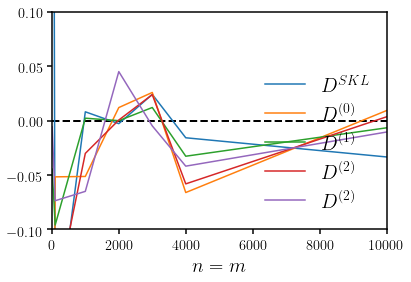

In [27]:
fig = plt.figure()
sub = fig.add_subplot(111)
#sub.plot([0., 1e4], [6.9990, 6.9990], c='k', lw=2, ls='--')
sub.plot([0., 1e4], [0., 0.], c='k', lw=2, ls='--')
sub.plot(ns, div00, label=r"$D^{SKL}$")
sub.plot(ns, div0, label=r"$D^{(0)}$")
sub.plot(ns, div1, label=r"$D^{(1)}$")
sub.plot(ns, div2, label=r"$D^{(2)}$")
sub.plot(ns, div3, label=r"$D^{(2)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$n = m$', fontsize=20)
sub.set_xlim([0., 1e4])
sub.set_ylim([-0.1, 0.1])

#### Test 4: 
Wang et al. (2009) Figure 6

In [28]:
mu_p = np.zeros(25)
mu_q = np.ones(25)
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.9999
            cov_q[i,j] = 0.9999

In [29]:
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for n in ns: 
    Xn = mvn(mu_p, cov_p, size=int(n))
    Yn = mvn(mu_q, cov_q, size=int(n))

    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        d00 += NG.kNNdiv_gauss(Xn, None, Knn=5, div_func='kl', gauss=Yn)
        d0 += divest0(Xn, Yn, k=1)
        d1 += divest1(Xn, Yn)
        d2 += divest2(Xn, Yn)
        d3 += divest3(Xn, Yn)
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(-0.1, 5)

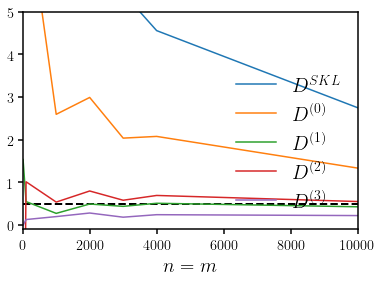

In [31]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 1e4], [0.5, 0.5], c='k', lw=2, ls='--')
sub.plot(ns, div00, label=r"$D^{SKL}$")
sub.plot(ns, div0, label=r"$D^{(0)}$")
sub.plot(ns, div1, label=r"$D^{(1)}$")
sub.plot(ns, div2, label=r"$D^{(2)}$")
sub.plot(ns, div3, label=r"$D^{(3)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$n = m$', fontsize=20)
sub.set_xlim([0., 1e4])
sub.set_ylim([-0.1, 5])

Redo multivariate example from Wang et al. (2009) Figure 2 keeping $n$ fixed but varying $m$

(0.0, 10.0)

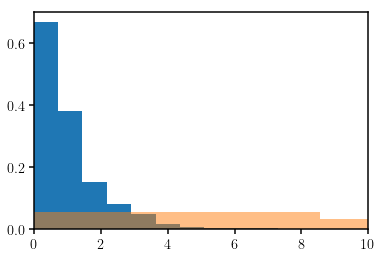

In [32]:
Xn = np.random.exponential(1., size=1000)
Yn = np.random.exponential(12, size=1000)
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(Xn, density=True)
sub.hist(Yn, density=True, alpha=0.5)
sub.set_xlim([0., 10.])

In [33]:
n = 2000
ms =[100, 500, 1000, 2000, 3000, 1e4]
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for m in ms: 
    Xn = np.random.exponential(1., size=int(n))
    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        Yn = np.random.exponential(12, size=int(m))
        d00 += NG.kNNdiv_gauss(Xn.reshape(-1,1), None, Knn=5, div_func='kl', gauss=Yn.reshape(-1,1))
        d0 += divest0(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d1 += divest1(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d2 += divest2(Xn.reshape(-1,1), Yn.reshape(-1,1))
        d3 += divest3(Xn.reshape(-1,1), Yn.reshape(-1,1))
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(0.0, 10000.0)

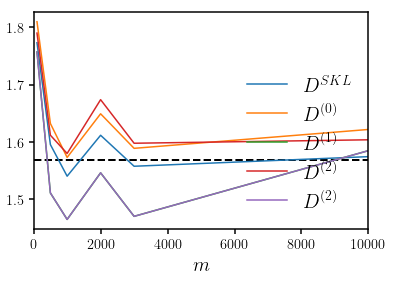

In [34]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 1e4], [1.5682, 1.5682], c='k', lw=2, ls='--')
sub.plot(ms, div00, label=r"$D^{SKL}$")
sub.plot(ms, div0, label=r"$D^{(0)}$")
sub.plot(ms, div1, label=r"$D^{(1)}$")
sub.plot(ms, div2, label=r"$D^{(2)}$")
sub.plot(ms, div3, label=r"$D^{(2)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$m$', fontsize=20)
sub.set_xlim([0., 1e4])

In [35]:
mu_p = np.array([0.1, 0.3, 0.6, 0.9])
mu_q = np.array([0., 0., 0., 0.])
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.5
            cov_q[i,j] = 0.1

In [36]:
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for m in ms: 
    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        Xn = mvn(mu_p, cov_p, size=int(n))
        Yn = mvn(mu_q, cov_q, size=int(m))
        d00 += NG.kNNdiv_gauss(Xn, None, Knn=5, div_func='kl', gauss=Yn)
        d0 += divest0(Xn, Yn, k=1)
        d1 += divest1(Xn, Yn)
        d2 += divest2(Xn, Yn)
        d3 += divest3(Xn, Yn)
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(0.0, 10000.0)

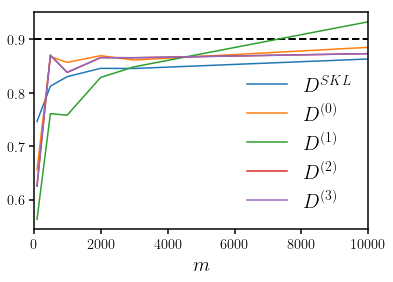

In [37]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 1e4], [0.9009, 0.9009], c='k', lw=2, ls='--')
sub.plot(ms, div00, label=r"$D^{SKL}$")
sub.plot(ms, div0, label=r"$D^{(0)}$")
sub.plot(ms, div1, label=r"$D^{(1)}$")
sub.plot(ms, div2, label=r"$D^{(2)}$")
sub.plot(ms, div3, label=r"$D^{(3)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$m$', fontsize=20)
sub.set_xlim([0., 1e4])

In [38]:
mu_p = np.zeros(25)
mu_q = np.ones(25)
cov_p = np.identity(len(mu_p))
cov_q = np.identity(len(mu_p))
for i in range(len(mu_p)): 
    for j in range(len(mu_p)): 
        if i != j: 
            cov_p[i,j] = 0.9999
            cov_q[i,j] = 0.9999

In [50]:
div00, div0, div1, div2, div3 = [], [], [], [], [] 
for m in ms: 
    d00, d0, d1, d2, d3 = 0., 0., 0., 0., 0.
    for i in range(5): 
        Xn = mvn(mu_p, cov_p, size=int(n))
        Yn = mvn(mu_q, cov_q, size=int(m))
        d00 += NG.kNNdiv_gauss(Xn, None, Knn=5, div_func='kl', gauss=Yn)
        d0 += divest0(Xn, Yn, k=1)
        d1 += divest1(Xn, Yn)
        d2 += divest2(Xn, Yn)
        d3 += divest3(Xn, Yn)
    div00.append(d00/5.)
    div0.append(d0/5.)
    div1.append(d1/5.)
    div2.append(d2/5.) 
    div3.append(d3/5.) 

(0.0, 5.0)

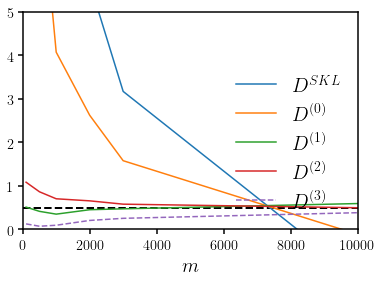

In [51]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 1e4], [0.5, 0.5], c='k', lw=2, ls='--')
sub.plot(ms, div00, label=r"$D^{SKL}$")
sub.plot(ms, div0, label=r"$D^{(0)}$")
sub.plot(ms, div1, label=r"$D^{(1)}$")
sub.plot(ms, div2, label=r"$D^{(2)}$")
sub.plot(ms, div3, ls='--', label=r"$D^{(3)}$")
sub.legend(loc='lower right', fontsize=20)
sub.set_xlabel('$m$', fontsize=20)
sub.set_xlim([0., 1e4])
sub.set_ylim([0., 5.])